# FLX_JP-BBY
partitioning FLUXNET-CH4 data from Bibai bog into diffusive and ebullitive fluxes

In [1]:
import pandas as pd
import numpy as np
import pywt
import wavefuncs as wave
import plotter as p

from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
from numpy.polynomial import Polynomial as P

In [2]:
# global plotting settings
plt.style.use('ggplot')
# text_kwargs = dict(ha='center', va='center', fontsize=28, color='C1') 

## Import data and process

In [3]:
df = wave.pd_read_from_drive('FLX_JP-BBY') # read from google drive into pd.DataFrame

In [4]:
df = df.replace(-9999, np.nan) # replace missing with nan
df['date'] = pd.to_datetime(df['TIMESTAMP_START'], format='%Y%m%d%H%M') # parse timestamp to new column 'date'
df = df.set_index(df['date'])

plot entire FCH4 series vs time

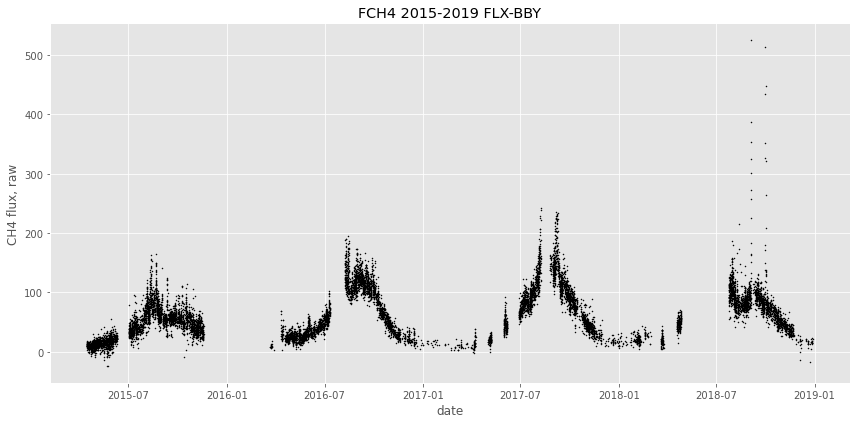

In [6]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(df['date'], df['FCH4'], c='k', s=1)
ax.set_ylabel("CH4 flux, raw")
ax.set_xlabel("date")
ax.set_title("FCH4 2015-2019 FLX-BBY")
plt.tight_layout()

ebullition ~2018-08?

In [7]:
dfw = df.loc['2018-07-01':'2019-01-01']

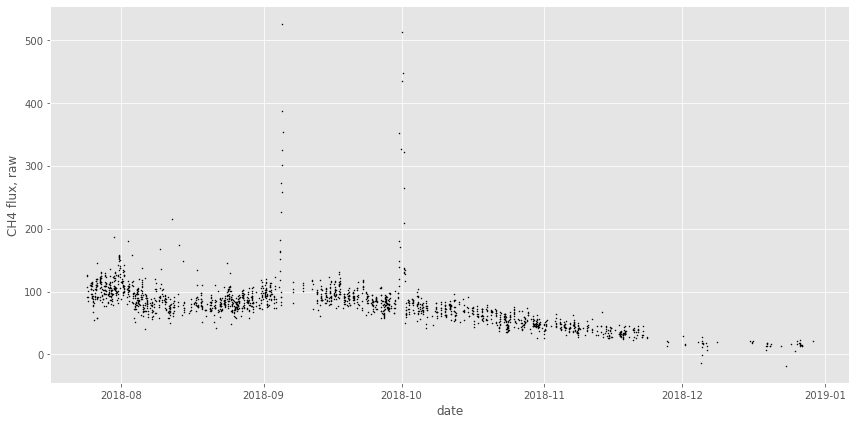

In [10]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(dfw.index, dfw['FCH4'], c='k', s=1)
ax.set_ylabel("CH4 flux, raw")
ax.set_xlabel("date")
plt.tight_layout()